# Create samples for mturk validation

**Author:** Jim Maddock

**Last Updated:** 9-30-20

**Description:**
* 45 minutes per 100 tasks (~ 30 seconds per task), 5 minutes per job
* \\$15 hour = \\$1.25 per job

In [7]:
import json
import pandas as pd
import numpy as np
from scipy import stats
import random

pd.set_option("display.min_rows", 100)
pd.set_option("display.max_rows", 100)

In [8]:
FILEPATH = '/Users/klogg/research_data/wmf_knowledge_graph/wiki_1300_72k_7-14-20/wiki_1300_72k_logs_5434743174174776460_taxo.json'

def loadClusters(filepath):

    with open(filepath) as json_file:
        cluster_65 = json.load(json_file)

    df = pd.DataFrame()

    for i, cluster in enumerate(cluster_65):
        chunk = []
        for article in cluster_65[cluster]['items']:
            row = {
                'label':cluster_65[cluster]['label'],
                'cluster':cluster_65[cluster]['cluster'],
                'w':article['w'],
                'title':article['title']
            }
            chunk.append(row)
        df = df.append(pd.DataFrame(chunk))
        #print('finished cluster: {0}'.format(i))

    df['title'] = df['title'].apply(lambda x: x.replace(' ','_'))
    df['cluster'] = pd.to_numeric(df['cluster'])
    
    return df

df = loadClusters(FILEPATH)

In [9]:
print('max articles per topic: {0}'.format(df.groupby('cluster').size().max()))
print('min articles per topic: {0}'.format(df.groupby('cluster').size().min()))

max articles per topic: 268
min articles per topic: 4


In [10]:
NUM_BINS = 13
SAMPLES_PER_BIN = 10
SAMPLE_FILEPATH = '/Users/klogg/research_data/wmf_knowledge_graph/mturk/sample_10-29-20.csv'

def getSample(df):
    out, bins = pd.qcut(df.groupby('cluster').size(),NUM_BINS, retbins=True)
    clusters_to_sample = out.to_frame('bin').groupby('bin').apply(lambda x: x.sample(SAMPLES_PER_BIN)).index.get_level_values('cluster').values
    sample = df.loc[df['cluster'].isin(clusters_to_sample)]
    return sample

sample = getSample(df)
sample.to_csv(SAMPLE_FILEPATH,index=False)

In [22]:
ARTICLES_PER_TASK = 5
TASKS_PER_JOB = 10
CODERS_PER_JOB = 3
PAY_RATE = 1.25

tasks = len(sample) / ARTICLES_PER_TASK
jobs = (tasks / TASKS_PER_JOB) * CODERS_PER_JOB
cost = (jobs * PAY_RATE) + (jobs * PAY_RATE * .2)

print('sample clusters: {0}'.format(sample['cluster'].nunique()))
print('sample articles: {0}'.format(len(sample)))
print('number of tasks: {0}'.format(tasks))
print('number of jobs: {0}'.format(jobs))
print('total cost: ${0}'.format(cost))

sample clusters: 130
sample articles: 7205
number of tasks: 1441.0
number of jobs: 432.29999999999995
total cost: $648.45


In [12]:
TASKS_FILEPATH = '/Users/klogg/research_data/wmf_knowledge_graph/mturk/tasks_10-29-20.csv'

sample['rand'] = np.random.rand(len(sample))
sample = sample.sort_values(['cluster','rand'])

task = 0
task_list = []
chunk = []

for i, article in sample.iterrows():
    
    if len(chunk) > 0 and article['cluster'] != chunk[-1]['cluster']:
        chunk = []
        task += 1
    
    row = {
        'label':article['label'],
        'cluster':article['cluster'],
        'title':article['title'],
        'task':task,
        'imposter':False
    }
    chunk.append(row)
    
    if len(chunk) % ARTICLES_PER_TASK == 0:
        imposter = df.loc[df['cluster'] != article['cluster']].sample().to_dict('records')[0]
        row = {
            'label':imposter['label'],
            'cluster':imposter['cluster'],
            'title':imposter['title'],
            'task':task,
            'imposter':True
        }
        task_list.extend(chunk)
        task_list.append(row)
        chunk = []
        task += 1

task_df = pd.DataFrame(task_list)

task_df.to_csv(TASKS_FILEPATH,index=False)


/Users/klogg/dev/knowledge_graph/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
TRIALS = 1000
n = int(len(df)/ARTICLES_PER_TASK)
sample_n = task_df['task'].nunique()

rand_df = pd.DataFrame({'rand':np.random.choice(a=[False, True], size=(n,), p=[.1,.9])})

sample_means = []
for x in range(TRIALS):
    sample_rand_df = rand_df.sample(sample['cluster'].nunique())
    sample_means.append(len(sample_rand_df.loc[sample_rand_df['rand'] == True])/len(sample_rand_df))
    
confidence_level = 0.95
degrees_freedom = len(sample_means) - 1
sample_mean = np.mean(sample_means)
sample_standard_error = stats.sem(sample_means)
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)

confidence_interval

print('real percent true: {0}'.format(len(rand_df.loc[rand_df['rand'] == True])/len(rand_df)))
print('simulated mean percent true: {0}'.format(sample_mean))
print('simulated 95% confidence interval: {0}'.format(confidence_interval))

real percent true: 0.9022302009252227
simulated mean percent true: 0.9018384615384617
simulated 95% confidence interval: (0.9002132851867921, 0.9034636378901313)


In [20]:
def format_title(title):
    title = title.replace("'","")
    return title

NUM_JOBS = None
NUM_CHUNKS = 10
JOBS_FILEPATH = '/Users/klogg/research_data/wmf_knowledge_graph/mturk/jobs_{0}_10-19-20.csv'

def stackForMturk(task_df, num_jobs=None, num_chunks=0):
    
    groups = [task_df for _, task_df in task_df.groupby('task')]
    random.shuffle(groups)
    task_df = pd.concat(groups).reset_index(drop=True)

    count = 0
    row = {}
    chunk = []
    task_list = []
    imposter_map = {}

    for i, article in task_df.iterrows():
        title = format_title(article['title'])
        q_num = count % (ARTICLES_PER_TASK + 1)
        block_num = int(count/(ARTICLES_PER_TASK + 1)) % TASKS_PER_JOB
        key = 'val_{0}_{1}'.format(block_num,q_num)
        row[key] = title
        if article['task'] not in task_list:
            task_list.append(article['task'])
        if article['imposter'] == True:
            imposter_map[article['task']] = title
        if block_num == TASKS_PER_JOB - 1 and q_num == ARTICLES_PER_TASK:
            row['task_batch'] = int(count/(ARTICLES_PER_TASK + 1))
            row['task_list'] = task_list
            row['imposter_map'] = imposter_map
            chunk.append(row)
            row = {}
            task_list = []
            imposter_map = {}
        count += 1

    mturk_df = pd.DataFrame(chunk)
    if num_jobs:
        mturk_df = mturk_df.sample(num_jobs)
    else:
        mturk_df = mturk_df.sample(frac=1)

    df_list = np.array_split(mturk_df, num_chunks)
    for i, chunk in enumerate(df_list):
        chunk.to_csv(JOBS_FILEPATH.format(i),index=False)
        
    return mturk_df

mturk_df = stackForMturk(task_df=task_df,
                         num_jobs=NUM_JOBS,
                         num_chunks=NUM_CHUNKS)

In [82]:
d = {}
for i in range(0,10):
    l = []
    for j in range(0,6):
        l.append('${val_'+str(i)+'_'+str(j)+'}')
    key = '${task_'+str(i)+'}'
    d[key] = l
            
d

{'${task_0}': ['${val_0_0}',
  '${val_0_1}',
  '${val_0_2}',
  '${val_0_3}',
  '${val_0_4}',
  '${val_0_5}'],
 '${task_1}': ['${val_1_0}',
  '${val_1_1}',
  '${val_1_2}',
  '${val_1_3}',
  '${val_1_4}',
  '${val_1_5}'],
 '${task_2}': ['${val_2_0}',
  '${val_2_1}',
  '${val_2_2}',
  '${val_2_3}',
  '${val_2_4}',
  '${val_2_5}'],
 '${task_3}': ['${val_3_0}',
  '${val_3_1}',
  '${val_3_2}',
  '${val_3_3}',
  '${val_3_4}',
  '${val_3_5}'],
 '${task_4}': ['${val_4_0}',
  '${val_4_1}',
  '${val_4_2}',
  '${val_4_3}',
  '${val_4_4}',
  '${val_4_5}'],
 '${task_5}': ['${val_5_0}',
  '${val_5_1}',
  '${val_5_2}',
  '${val_5_3}',
  '${val_5_4}',
  '${val_5_5}'],
 '${task_6}': ['${val_6_0}',
  '${val_6_1}',
  '${val_6_2}',
  '${val_6_3}',
  '${val_6_4}',
  '${val_6_5}'],
 '${task_7}': ['${val_7_0}',
  '${val_7_1}',
  '${val_7_2}',
  '${val_7_3}',
  '${val_7_4}',
  '${val_7_5}'],
 '${task_8}': ['${val_8_0}',
  '${val_8_1}',
  '${val_8_2}',
  '${val_8_3}',
  '${val_8_4}',
  '${val_8_5}'],
 '${task_9

In [24]:
TASKS_FILEPATH = '/Users/klogg/research_data/wmf_knowledge_graph/mturk/tasks_10-29-20.csv'
task_df.to_csv(TASKS_FILEPATH,index=False)

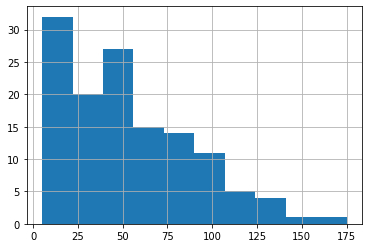

In [28]:
task_df.loc[task_df['imposter'] == False].groupby('cluster')['cluster'].size().hist()